# Quadratic Linear Analysis (QDA)

**Objective**:
 demonstrate how QDA works for classification.

**Assumptions**
- all features are normal distributed.
- all features are uncorrelated
- ~~all classes displays the same covariance matrix~~

In [104]:
import numpy as np
import pandas as pd
import seaborn as sns

### Example 1: two predictors with differente correlation matrices

Creating the data

            xA         xB        fx  y
136  12.610865 -10.924324  1.686541  1
257   7.119439  -9.178628 -2.059189  0
592  15.756551  -6.474808  9.281743  1
438  17.554824 -13.781094  3.773729  1
531  13.997904  -5.158835  8.839068  1


<AxesSubplot:xlabel='value', ylabel='Count'>

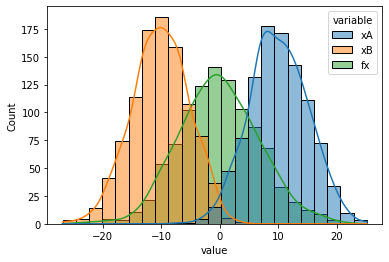

In [105]:
#features X
meanA, stdA = 10, 5
xA = np.random.normal(meanA, stdA, 1000)

meanB, stdB = -10, 5
xB = np.random.normal(meanB, stdB, 1000)

#target y
fx = xA + xB
y = [1 if i >= (meanA + meanB) else 0 for i in fx]

#data with X an y
data = pd.DataFrame({'xA':xA, 'xB':xB, 'fx': fx, 'y':y})
print(data.sample(5))

sns.histplot(data=pd.melt(data, id_vars=['y'], value_vars=['xA', 'xB', 'fx']), x='value', hue='variable', kde=True)

Checking the covariance matrices

In [106]:
#separing the data
sample0 = data.loc[data['y'] == 0]
sample1 = data.loc[data['y'] == 1]
assert data.shape[0] == sample0.shape[0] + sample1.shape[0]

#calculating the covariance matrices
print(sample0[['xA', 'xB']].cov())
print(sample1[['xA', 'xB']].cov())

           xA         xB
xA  16.794555  -9.226566
xB  -9.226566  18.089364
           xA         xB
xA  16.648352  -7.424631
xB  -7.424631  16.000445


The results above shows the differente between the covariance matrices, which is an indication that QDA should be a better suggestion. Since the QDA's decision function is a curve, it would allow more flexibility than the LDA's decision function, which is a straight line, thus resulting in lower bias.

QDA's decision function:

<img src="img/qda_decision_function.PNG" />

*source: https://www.statlearning.com/*

In [107]:
def preparation(df):
    '''calculate every variable (except x and xt) necessary for the decision equation'''

    sample0 = data.loc[data['y'] == 0]
    sample1 = data.loc[data['y'] == 1]

    m0 = sample0[['xA','xB']].mean().array.reshape(2,1)
    m0_t = sample0[['xA','xB']].mean().array
    m1 = sample1[['xA','xB']].mean().array.reshape(2,1)
    m1_t = sample1[['xA','xB']].mean().array

    cov0 = sample0[['xA', 'xB']].cov().to_numpy()
    cov0_inv = np.linalg.inv(sample0[['xA', 'xB']].cov())
    cov1 = sample1[['xA', 'xB']].cov().to_numpy()
    cov1_inv = np.linalg.inv(sample1[['xA', 'xB']].cov())

    ln0, ln1 = np.linalg.det(cov0), np.linalg.det(cov1)
    prob0, prob1 = (sample0.shape[0]/data.shape[0]), (sample1.shape[0]/data.shape[0])

    return m0, m0_t, m1, m1_t, cov0_inv, cov1_inv, ln0, ln1, prob0, prob1


#calculating each variable of the equation
m0, m0_t, m1, m1_t, cov0_inv, cov1_inv, ln0, ln1, prob0, prob1 = preparation(data)

In [108]:
def decision_function(x, x_t, m, m_t, cov_inv, ln, prob):
    '''create the function for each row'''
    fx = -0.5 * np.matmul(np.matmul(x_t, cov_inv), x) + \
              + np.matmul(np.matmul(x_t, cov_inv), m) + \
         -0.5 * np.matmul(np.matmul(m_t, cov_inv), m) + \
         -0.5 * ln + prob               
    return fx[0]


#calculating the decision function
data['fx0'] = np.nan
data['fx1'] = np.nan
data['qda_prediction'] = np.nan

for index, row in data.iterrows():
    x_t = data[['xA','xB']].loc[index].array
    x = data[['xA','xB']].loc[index].array.reshape(2,1)

    data.loc[index, 'fx0'] = decision_function(x, x_t, m0, m0_t, cov0_inv, ln0, prob0)
    data.loc[index, 'fx1'] = decision_function(x, x_t, m1, m1_t, cov1_inv, ln1, prob1)
    data['qda_prediction'] = np.where(data['fx1'] >= data['fx0'], 1, 0)

data

,xA,xB,fx,y,fx0,fx1,qda_prediction
0,7.364575,-11.774838,-4.410263,0,-108.845494,-107.891930,1
1,11.280773,-13.950333,-2.669560,0,-109.311103,-107.271603,1
2,11.428865,-6.312893,5.115973,1,-112.124683,-105.227833,1
3,6.698252,-17.123181,-10.424929,0,-109.737529,-112.395264,0
4,12.954100,-11.383189,1.570911,1,-110.477295,-105.740547,1
...,...,...,...,...,...,...,...
995,6.024311,-8.476358,-2.452046,0,-109.314849,-107.243987,1
996,11.581728,-13.098697,-1.516969,0,-109.489073,-106.723241,1
997,9.268479,-12.014967,-2.746488,0,-109.036132,-107.050491,1
998,0.720112,-11.208824,-10.488712,0,-110.305750,-112.956796,0
